Package for computing VOC PASCAL mAP

In [ ]:
!pip install mean_average_precision

Used to Compute Evaluation Metrics for UAV Model. The basics are similar to the training notebooks, differences will be recorded in the notes here.

In [ ]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import time
import random
import warnings
import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from datetime import datetime
from mean_average_precision import MetricBuilder

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

DRIVE = "/content/drive/MyDrive/CNN/UAV"
IMAGE_ZIP = "images.zip"
IMAGES = f"{DRIVE}/{IMAGE_ZIP}"
ANNOTATION_DIR = f"{DRIVE}/annotations"
BASE_IMAGE_DIR = f"/content/images"
ANNOTATION_FILES = [f"{ANNOTATION_DIR}/{d}" for d in os.listdir(ANNOTATION_DIR) if ".csv" in d]
EDETS = [d for d in os.listdir(DRIVE) if '.pth' in d]
ANNOTATION_FILES.sort()
EDETS.sort()
os.environ["DRIVE"] = DRIVE
os.environ["IMAGE_ZIP"] = IMAGE_ZIP
os.environ["IMAGES"] = IMAGES
os.environ["ANNOTATION_DIR"] = ANNOTATION_DIR
os.environ["BASE_IMAGE_DIR"] = BASE_IMAGE_DIR


In [ ]:
%%bash

cp $IMAGES /content
unzip -q $IMAGE_ZIP
rm $IMAGE_ZIP

pip install -U -q albumentations
pip install -q omegaconf
pip install -q timm
pip install -q effdet

In [ ]:
IMAGE_DIRS = [f"{BASE_IMAGE_DIR}/{d}" for d in os.listdir(BASE_IMAGE_DIR) if d != '.DS_Store']
IMAGE_DIRS.sort()

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

TRAIN_SIZE = 512
VAL_SIZE = 512
NUM_CLASSES = 1
BATCH_SIZE = 8
NUM_WORKERS = 4
D_SIZE = 0

In [ ]:
class TrainGlobalConfig:
  def __init__(self,
               num_workers,
               project_folder,
               batch_size):

    self.num_workers = num_workers
    self.batch_size = batch_size


    self.folder = f"{DRIVE}/{project_folder}"


global_config = TrainGlobalConfig(batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  project_folder=f"effdet{D_SIZE}-4-2_512x640")

# Load and Transform Data

In [ ]:
def get_train_and_val(rand=6189):
  annotation_list = []
  seq_list = []
  col_names = ["frame_id", "object_id", "x", "y", "width", "height", "object_class",
               "species", "occluded", "noisy_frame"]
  for annot, image_dir in zip(ANNOTATION_FILES, IMAGE_DIRS):
    if ".csv" in annot:
      annotation_list.append(pd.read_csv(annot, header=None,
                         names=col_names))
      annotation_list[-1]['csv'] = annot.split("/")[-1]
      images = [f"{image_dir}/{d}" for d in os.listdir(image_dir)]
      img_shape = cv2.imread(images[0]).shape[:2]
      frames = [int(img.split("_")[-1].split(".")[0]) for img in images]
      frame_df = pd.DataFrame({"frame_id": frames, "file": images})
      frame_df["csv"] = f"{image_dir.split('/')[-1]}.csv"
      frame_df["img_height"] = img_shape[0]
      frame_df["img_width"] = img_shape[1]
      seq_list.append(frame_df)
  frame_df = pd.concat(seq_list).reset_index(drop=True)
  annotations = pd.concat(annotation_list).merge(frame_df).reset_index(drop=True)
  
  while True:
    train_files, val_files = train_test_split(frame_df[['csv']].drop_duplicates(),
                                              test_size=0.2,
                                              random_state=rand)
    val_df = frame_df[frame_df['csv'].isin(val_files['csv'])].reset_index(drop=True)
    train_df = frame_df[frame_df['csv'].isin(train_files['csv'])].reset_index(drop=True)
    val_frac = val_df['file'].nunique()/frame_df['file'].nunique()
    if val_frac < 0.22 and val_frac > 0.18:
        break
    rand += 1
  train_annotations = annotations[annotations['csv'].isin(train_files['csv'])].reset_index(drop=True)
  val_annotations = annotations[annotations['csv'].isin(val_files['csv'])].reset_index(drop=True)
  return train_df, val_df, train_annotations, val_annotations
train_df, val_df, train_annotations, val_annotations = get_train_and_val()

**Transformations**

**Generic UAV Dataset**

In [ ]:
class UAVDataset(Dataset):
  
  def __init__(self, meta_data,
               boxes,
               transform=None,
               image_size=None):
    super(UAVDataset).__init__()
    
    self.meta_data = meta_data
    self.boxes = boxes
    if type(image_size) == int:
      self.image_size = (image_size, image_size)
    else:
      self.image_size = image_size
    self.transform = transform(self.image_size) if transform else None
    
  def _box_to_tensor(self, sample, target):
    """Convert boundind box array to tensor"""
    if len(sample["bboxes"]) > 0:
      target["bboxes"] = torch.tensor(sample["bboxes"])
    else:
      target["bboxes"] = torch.zeros((0,4))
      # Convert bounded box to yxyx format
    #target["bboxes"][:,[0,1,2,3]] = target["bboxes"][:,[1,0,3,2]]
    return target
  
  def __len__(self) -> int:
    """Returns the number of images."""
    return self.meta_data.shape[0]

  def load_image_and_boxes(self, image_meta, image_boxes):
    """Loads image corresponding to image_meta row.
       Converts bounding boxes to x_min, y_min, x_max, y_max format.
    """
    image = cv2.imread(image_meta["file"]).astype(np.float32)/ 255.0
    bboxes = image_boxes[["x", "y", "width", "height"]].values
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[bboxes[:, 2] > image_meta["img_width"], 2] = image_meta["img_width"]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    bboxes[bboxes[:, 3] > image_meta["img_height"], 3] = image_meta["img_height"]
    return image, bboxes

**Validation Data**

In [ ]:
BBOX = A.BboxParams(
             format='pascal_voc',
             min_area=0, 
             min_visibility=0,
             label_fields=['labels'])

def get_val_transform(img_size):
  """Returns a function to perform the standard sequence of preprocessing steps
     for validation data.
  """
  return A.Compose([A.LongestMaxSize(max_size=img_size[1],
                                     p=1.0),
                    A.PadIfNeeded(min_height=img_size[0],
                                  min_width=img_size[1],
                                  border_mode=0,
                                  p=1.0),
                    ToTensorV2(p=1.0)],
                   bbox_params=BBOX, 
                   p=1.0)
  
def get_val_crop(img_size):
  min_dim = min(img_size)
  return A.Compose([A.CenterCrop(height=min_dim,
                                 width=min_dim,
                                  p=1.0),
                    A.Resize(512, 512, p=1.0),
                    ToTensorV2(p=1.0)],
                   bbox_params=BBOX, 
                   p=1.0)

In [ ]:
class ValDataset(UAVDataset):

  def __init__(self, meta_data,
               boxes,
               image_size,
               transform=None):
    super(ValDataset, self).__init__(meta_data, boxes, transform, image_size)

  def __getitem__(self, index: int):
    """Retrieves the image and boxes with the specified index."""
    image_meta = self.meta_data.loc[index]
    image_boxes = self.boxes[self.boxes["file"] == image_meta["file"]]
    image, bboxes = self.load_image_and_boxes(image_meta, image_boxes)
    labels = torch.ones(bboxes.shape[0], dtype=torch.int64)
    target = {"bboxes": bboxes,
              "labels": labels}
    
    if self.transform:
      sample = self.transform(image=image,
                              bboxes=target["bboxes"],
                              labels=target["labels"])
      image, target = sample['image'], self._box_to_tensor(sample, target)
    return image, target, index

Image sizes for validation, validation with cropping, and validation the training set.

In [ ]:
val_sizes = {"0000000067_0000000019.csv": [512, 640],
             "0000000067_0000000046.csv": [512, 640],
             "0000000067_0000000050.csv": [512, 640],
             "0000000067_0000000052.csv": [512, 640],
             "0000000354_0000000000.csv": [512, 640],
             "0000000359_0000000000.csv": [384, 640],
             "0000000363_0000000000.csv": [384, 640]}

val_crop = {"0000000067_0000000019.csv": [512, 640],
             "0000000067_0000000046.csv": [512, 640],
             "0000000067_0000000050.csv": [512, 640],
             "0000000067_0000000052.csv": [512, 640],
             "0000000354_0000000000.csv": [416, 637],
             "0000000359_0000000000.csv": [333, 699],
             "0000000363_0000000000.csv": [321, 700]}

train_sizes = {"0000000010_0000000000.csv": [512, 640],
               "0000000054_0000000000.csv":	[512, 640],
               "0000000056_0000000000.csv":	[512, 640],
               "0000000062_0000000000.csv":	[512, 640],
               "0000000067_0000000005.csv":	[512, 640],
               "0000000067_0000000012.csv":	[512, 640],
               "0000000067_0000000014.csv":	[512, 640],
               "0000000067_0000000015.csv":	[512, 640],
               "0000000067_0000000024.csv":	[512, 640],
               "0000000067_0000000025.csv": [512, 640],
               "0000000067_0000000026.csv":	[512, 640],
               "0000000067_0000000027.csv":	[512, 640],
               "0000000067_0000000028.csv":	[512, 640],
               "0000000067_0000000029.csv":	[512, 640],
               "0000000067_0000000031.csv":	[512,	640],
               "0000000067_0000000032.csv":	[512, 640],
               "0000000067_0000000040.csv":	[512,	640],
               "0000000067_0000000041.csv":	[512,	640],
               "0000000067_0000000045.csv":	[512,	640],
               "0000000067_0000000055.csv":	[512,	640],
               "0000000067_0000000058.csv":	[512,	640],
               "0000000067_0000000059.csv": [512, 640],
               "0000000351_0000000000.csv":	[512,	896],
               "0000000364_0000000000.csv":	[384,	768],
               "0000000367_0000000000.csv":	[384, 768]}

Constructs the validation datasets. train_val is validation on training data, val is validation on validation data, and val_crop is validation on cropped validation data.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch)) 

def get_val_dataset_dict(df,
                     annotations,
                     dataset,
                     get_transforms,
                     size_dict):
  dataset_dict = {}
  dataset_loaders = {}
  for csv in df["csv"].unique():
    csv_df = df[df["csv"] == csv].sort_values('frame_id').reset_index(drop=True)
    img_height, img_width = csv_df["img_height"].iloc[0], csv_df["img_width"].iloc[0]
    annot = annotations[annotations["csv"] == csv]
    dataset_dict[csv] = dataset(meta_data=csv_df,
                                boxes=annot,
                                image_size=size_dict[csv],
                                transform=get_transforms)
    dataset_loaders[csv] = torch.utils.data.DataLoader(dataset_dict[csv], 
                                                       batch_size=global_config.batch_size,
                                                       num_workers=global_config.num_workers,
                                                       sampler=SequentialSampler(dataset_dict[csv]),
                                                       shuffle=False,
                                                       pin_memory=False,
                                                       collate_fn=collate_fn)
  return dataset_dict, dataset_loaders

train_val_datasets, train_val_loaders = get_val_dataset_dict(train_df,
                                                             train_annotations,
                                                             ValDataset,
                                                             get_val_transform,
                                                             size_dict=train_sizes)

val_datasets, val_loaders = get_val_dataset_dict(val_df,
                                                 val_annotations,
                                                 ValDataset,
                                                 get_val_transform,
                                                 size_dict=val_sizes)

val_crop_d, val_crop_l = get_val_dataset_dict(val_df,
                                                 val_annotations,
                                                 ValDataset,
                                                 get_val_crop,
                                                 size_dict=val_crop)

Constructs the neural network, loading weights from the checkpoint.

In [ ]:
def load_net(checkpoint_path, d_size, image_size):
    config = get_efficientdet_config(f'tf_efficientdet_d{d_size}')
    config.num_classes = 1
    config.image_size=image_size
    net = EfficientDet(config, pretrained_backbone=False)


    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    checkpoint = torch.load(checkpoint_path)
    net.to(torch.device('cuda:0'))
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    net = DetBenchPredict(net)
    net.eval();
    return net.cuda()

Makes a list of predictions for images.

In [ ]:
def make_prediction(net, images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        image_size = torch.tensor(images.shape[2:])
        image_size.unsqueeze_(-1)
        image_size = image_size.expand(2,images.shape[0]).transpose(1, 0)
        det = net(images)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

Converts the predictions into a dataframe. Score threshold is the threshold for detecting an object; nms_threshold is used by non-max suppresion to remove duplicate boxes.

In [ ]:
def make_prediction_df(net, test_loader, score_threshold=0.5, nms_threshold=0.2):
  results = []
  n = 0
  for images, labels, image_id in test_loader:
    n +=1
    predictions = make_prediction(net, images, score_threshold=score_threshold)[0]
    for i, image in enumerate(images):
      boxes, scores = nms(predictions[i]['boxes'], predictions[i]['scores'], nms_threshold)
      true_boxes = labels[i]['bboxes']
      
      result = {
            'image_id': image_id[i],
            'true_boxes': true_boxes,
            'scores': scores,
            'boxes': boxes
          }
      results.append(result)
    if n % 1000 == 0:
      print(f"Processed batch {n}.")
  
  return pd.DataFrame(results)

Performs non-max suppresion.

In [ ]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

An example image with ground truth bounding boxes in red and predicted boxes in blue. This is one of the most challenging videos.

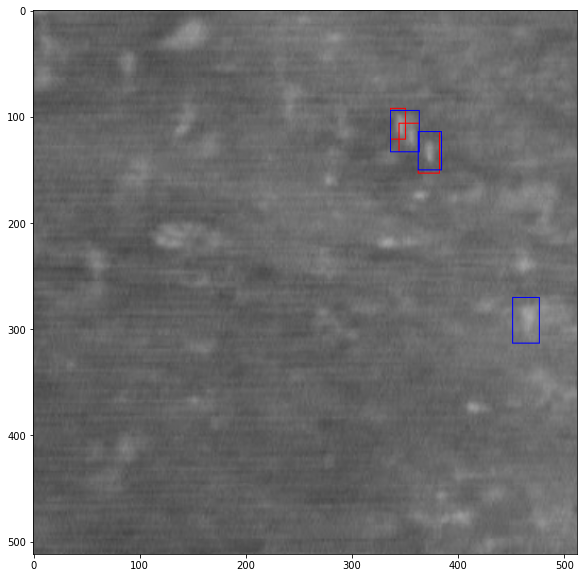

In [ ]:
plt.figure(figsize=(10,10))
img = X2.numpy().transpose((1,2,0)).copy()
boxes, scores = nms(pred2[0]['boxes'], pred2[0]['scores'], 0.2)
for n in range(y2['bboxes'].shape[0]):
  bbox = [int(b) for b in y2['bboxes'][n]]
  cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 1)
for box in boxes:
  bbox = [int(b) for b in box]
  cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 1)
plt.imshow(img)

Computes mAP for all the validation videos given a model checkpoint.

In [ ]:
for k in val_sizes:
  val_net = load_net(f"{global_config.folder}/best-checkpoint-012epoch.bin", D_SIZE,  val_sizes[k])
  results = make_prediction_df(val_net, val_crop_l[k], score_threshold=0.1)
  metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
  for _, row in results.iterrows():
    gt = row['true_boxes'].numpy()
    gt = np.concatenate([gt, np.zeros((gt.shape[0], 3))], axis=1)
    scores = np.array(row['scores'])[...,np.newaxis]
    pred = row['boxes']
    if len(pred) > 0:
      pred = np.concatenate([np.stack(pred), np.zeros(scores.shape), scores], axis=1)
    else:
      pred = np.zeros((scores.shape[0], 5))
    metric_fn.add(pred, gt)
  print(k)
  print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.2, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

0000000067_0000000019.csv
VOC PASCAL mAP: 0.8162717819213867
0000000067_0000000046.csv
VOC PASCAL mAP: 0.7852025032043457
0000000067_0000000050.csv
VOC PASCAL mAP: 0.6090683937072754
0000000067_0000000052.csv
VOC PASCAL mAP: 0.20876795053482056
0000000354_0000000000.csv
VOC PASCAL mAP: 0.03318541869521141
0000000359_0000000000.csv
VOC PASCAL mAP: 0.39614078402519226
0000000363_0000000000.csv
VOC PASCAL mAP: 0.2238289713859558
